In [1]:
import pandas as pd
import numpy as np
import json

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,make_scorer,fbeta_score
from sklearn.metrics import average_precision_score,plot_precision_recall_curve,precision_recall_curve
from sklearn.metrics import roc_auc_score,roc_curve, auc

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from sklearn.ensemble import GradientBoostingClassifier
import clean_text as ct

In [2]:
# tweets = pd.read_csv('climate_change_tweets_sample-2020-05-16-17-57.csv')
# tweets.head()

In [3]:
# clean_text = ct.CleanText()
# tweets["text"] = clean_text.fit_transform(tweets.text)
# tweets.to_csv("clean_tweets.csv") # save once processed

In [4]:
tweets = pd.read_csv("clean_tweets.csv") # read in instead
tweets = tweets.loc[(~tweets.text.isnull()), :]
tweets.head()

,Unnamed: 0,username,user_handle,date,retweets,favorites,text,label
0,0,WWF Climate & Energy,climateWWF,2020-04-28,11,22,econom recoveri nation climat pledg must desig...,0
1,1,WWF Climate & Energy,climateWWF,2020-04-22,6,16,difficult time hard connect natur world earthd...,0
2,2,WWF Climate & Energy,climateWWF,2020-04-01,43,69,decis postpon cop unavoid collect prioriti mus...,0
3,3,WWF Climate & Energy,climateWWF,2020-03-30,24,30,japan world fifth largest emitt greenhous gase...,0
4,4,WWF Climate & Energy,climateWWF,2020-03-30,22,40,countri includ naturebasedsolut climat plan nd...,0


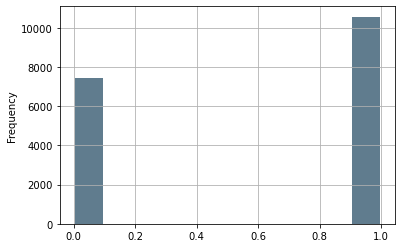

In [5]:
#show labels frequencies
tweets['label'].plot.hist(grid=True, rwidth=0.9,color='#607c8e')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(tweets.text, tweets.label, 
                                                    test_size=0.2, random_state=17, 
                                                    shuffle=True) # explicit default

In [7]:
BOW_vectorizer = CountVectorizer(stop_words = 'english', 
                                 binary=True, # Creates 0/1 "One Hot" vector; 
                                              # np.unique(BOW_train.toarray())
                                 min_df = 10)
BOW_vectorizer.fit(X_train)
BOW_train = BOW_vectorizer.transform(X_train)
BOW_test = BOW_vectorizer.transform(X_test)

scaler_BOW = MaxAbsScaler()

BOW_train_scaled = scaler_BOW.fit_transform(BOW_train)
BOW_test_scaled = scaler_BOW.transform(BOW_test)

In [8]:
BIGRAMS_vectorizer = CountVectorizer(stop_words = 'english', 
                                 binary=True, # Creates 0/1 "One Hot" vector; 
                                              # np.unique(BOW_train.toarray())
                                 min_df = 10,
                                 ngram_range = (1,2))

BIGRAMS_vectorizer.fit(X_train)
BIGRAMS_train = BIGRAMS_vectorizer.transform(X_train)
BIGRAMS_test = BIGRAMS_vectorizer.transform(X_test)

scaler_BIGRAMS = MaxAbsScaler()

BIGRAMS_train_scaled = scaler_BIGRAMS.fit_transform(BOW_train)
BIGRAMS_test_scaled = scaler_BIGRAMS.transform(BOW_test)

In [9]:
FBOW_vectorizer = CountVectorizer(stop_words = 'english', 
                                  binary=False, # Creates Word Frequency Vector; 
                                                # # np.unique(FBOW_train.toarray())
                                  min_df = 10)
FBOW_vectorizer.fit(X_train)
FBOW_train = FBOW_vectorizer.transform(X_train)
FBOW_test = FBOW_vectorizer.transform(X_test)

scaler_FBOW = MaxAbsScaler()

FBOW_train_scaled = scaler_FBOW.fit_transform(FBOW_train)
FBOW_test_scaled = scaler_FBOW.transform(FBOW_test)

In [10]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', 
                                   min_df=10) # used for now for consistency
tfidf_vectorizer.fit(X_train)
tfidf_train = tfidf_vectorizer.transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

scaler_tfidf = MaxAbsScaler()

tfidf_train_scaled = scaler_tfidf.fit_transform(tfidf_train)
tfidf_test_scaled = scaler_tfidf.transform(tfidf_test)

In [11]:
def plot_figure(X,y,clf,name):


    y_score = clf.decision_function(X)
    average_precision = average_precision_score(y, y_score)

    print('Average precision-recall score: {0:0.2f}'.format(
          average_precision))

    fig, axes = plt.subplots(figsize=(12,4),nrows=1,ncols=2)
    disp = plot_precision_recall_curve(clf, X, y,ax=axes[0])
    disp.ax_.set_title('2-class Precision-Recall curve: '
                       'AP={0:0.2f}'.format(average_precision))
    axes[0].legend(loc="upper right")


    fpr, tpr, _ = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)

    #plt.figure()
    lw = 2
    axes[1].plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    axes[1].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Receiver Operating Characteristic Curve')
    axes[1].legend(loc="lower right")
    plt.show()
    fig.savefig('GB/{}.png'.format(name))

In [28]:
keys = ['BOW','BOW_scaled','BIGRAMS','BIGRAMS_scaled','FBOW','FBOW_scaled','TF_IDF','TF_IDF_scaled']
values = [(BOW_train,BOW_test),(BOW_train_scaled,BOW_test_scaled),
          (BIGRAMS_train,BIGRAMS_test),(BIGRAMS_train_scaled,BIGRAMS_test_scaled),
          (FBOW_train,FBOW_test),(FBOW_train_scaled,FBOW_test_scaled),
          (tfidf_train,tfidf_test),(tfidf_train_scaled,tfidf_test_scaled)]

d = {k:v for k,v in zip(keys,values)}

In [29]:
df = pd.DataFrame(data=None,columns=['scenario','accuracy','auc','params'])

In [30]:
n_HP_points_to_test = 100

param_test ={"loss":["deviance","exponential"],
            "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
            "min_samples_split": np.linspace(0.1, 0.5, 12),
            "min_samples_leaf": np.linspace(0.1, 0.5, 12),
            "max_depth":[3,5,8],
            "max_features":["log2","sqrt"],
            "criterion": ["friedman_mse",  "mae"],
            "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0]}

c:\users\jason\anaconda3\envs\sl\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


------------------------------------------------------------------------------
------------------------------------------------------------------------------

scenario: BOW
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed:   12.4s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   15.4s finished



##########
Accuracy: 0.5936
Precision: 0.5936
Recall: 1.0
f1_score: 0.7449
f2_score: 0.8795
f5_score: 0.9743
auc_score: 0.5
##########


Average precision-recall score: 0.59


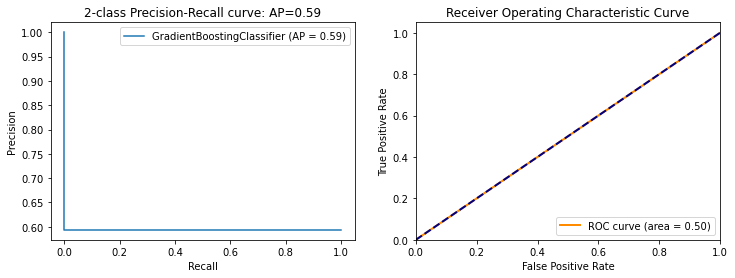


------------------------------------------------------------------------------
------------------------------------------------------------------------------

scenario: BOW_scaled
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s


KeyboardInterrupt: 

In [32]:
for case,X in tqdm_notebook(d.items()):
    
    print('------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------')
    print()
    print('scenario: {}'.format(case))
    
    X_train,X_test = X


    kfcv = KFold(n_splits=5,shuffle=True,random_state=101)


    
    clf = GradientBoostingClassifier(max_depth=-1, random_state=17, n_estimators=100)
    
    gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='accuracy',
    cv=kfcv,
    refit=True,
    random_state=17,
    n_jobs=-1,
    verbose=10)
    
    gs.fit(X_train, y_train)
    
    
    best_grid = gs.best_estimator_
    best_params = gs.best_params_
    
    
    print()
    pred = best_grid.predict(X_test)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    f2 = fbeta_score(y_test,pred,beta=2)
    f5 = fbeta_score(y_test,pred,beta=5)
    auc_score = roc_auc_score(y_test,pred)

    print('##########')
    print('Accuracy: {}'.format(round(accuracy,4)))
    print('Precision: {}'.format(round(precision,4)))
    print('Recall: {}'.format(round(recall,4)))
    print('f1_score: {}'.format(round(f1,4)))
    print('f2_score: {}'.format(round(f2,4)))
    print('f5_score: {}'.format(round(f5,4)))
    print('auc_score: {}'.format(round(auc_score,4)))

    print('##########')
    print()
    print()
    
    new = pd.DataFrame({'scenario':case,'accuracy':accuracy,'auc':auc_score,'params':json.dumps(best_params)}, index=[0])
    df = pd.concat([df,new], ignore_index=True)
    
    plot_figure(X_test,y_test,best_grid,case)
    
    print()

df.to_csv('GB/GradientBoostingGridSearch.csv', index=False)  